In [1]:
%pip install torchvision
%pip install torch --index-url https://download.pytorch.org/whl/cu118
%pip install tqdm

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour chang

/Users/minze/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/minze/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/minze/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 56.0.0 or later, but libpng16.16.dylib provides version 54.0.0'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


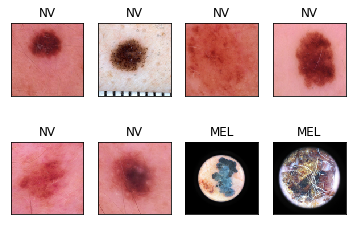

In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

train_folder = ImageFolder('a5_data_new/train', transform=torchvision.transforms.ToTensor())
#train_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/train', transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(train_loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])


In [2]:
import torch
import torchvision
val_folder = ImageFolder('a5_data_new/val', transform=torchvision.transforms.ToTensor())
#val_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/val', transform=torchvision.transforms.ToTensor())
val_loader = DataLoader(val_folder, batch_size=8, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
    
def train_classifier(model, train_data, val_data, hyperparams):

    # Deals with model updates. Adam is more effective than SGD.
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])    
    
    # Binary Cross-entropy loss because we have 2 classes.
    # Note that the softmax is "baked into" this loss, so we should not
    # use a softmax at the end.
    loss_func = torch.nn.BCELoss()
      
    # Some statistics.
    acc_history = []
    min_val_loss= float('inf')
    for epoch in range(hyperparams['max_epochs']):

        # Set the model in training mode, enabling dropout if we use that.
        model.train()
        
        loss_sum = 0

        # For each batch
        for Xbatch, Ybatch in tqdm(train_data):
            # Apply the model. We don't know at this point what the model is.
            # The output should be of the shape (batch_size, 10).
            outputs = model(Xbatch)
     
            # Apply the cross-entropy loss.
            loss = loss_func(outputs.squeeze(), Ybatch.float())

            # Update the model.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()

        # Set the model in evaluation mode. Disables dropout if present.
        model.eval()
        with torch.no_grad():
            # Compute the accuracy on the validation data.
            val_acc, val_loss = predict_and_evaluate(model, val_data)
                
        mean_loss = loss_sum / len(train_data)
        
        acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}: train loss = {mean_loss:.4f}, val acc = {val_acc:.4f}, val loss = {val_loss:.4f}')

        if val_loss < min_val_loss:
            min_val_loss = val_loss
        elif val_loss > min_val_loss:
            break

    return acc_history
        
    
# A utility function to compute accuracies during training.
def predict_and_evaluate(model, data):
    loss_func = torch.nn.BCELoss()
    loss_sum = 0
    all_gold = []
    all_pred = []

    for Xbatch, Ybatch in data:
        outputs = model(Xbatch)
        loss = loss_func(outputs.squeeze(), Ybatch.float())
        loss_sum += loss.item()

        predictions = torch.round(outputs)

        all_gold.extend(Ybatch.numpy())
        all_pred.extend(predictions.numpy())
    mean_loss = loss_sum / len(data)
    return accuracy_score(all_gold, all_pred), mean_loss

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel rgb
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.conv3 = nn.Conv2d(64,128, kernel_size=ks)
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.output = nn.Linear(512, 1)

    def flatten_size(self, ks):
        if ks == 3:
            return 128*14*14
        elif ks == 5:
            return 128*12*12
        else: 
            return 0 
           
    def forward(self, X):
        c1 = self.conv1(X)
        fm1 = F.max_pool2d(F.relu(c1), 2)

        c2 = self.conv2(fm1)
        fm2 = F.max_pool2d(F.relu(c2), 2)

        c3 = self.conv3(fm2)
        fm3 = F.max_pool2d(F.relu(c3), 2)
        # This was used to calculate flattened size
        #print(fm3.shape)
        fl = torch.flatten(fm3, start_dim=1)

        h1 = F.relu(self.fc(fl))
        out = torch.sigmoid(self.output(h1))
        return out

In [8]:
torch.random.manual_seed(2)
cnn = CNN(3)
history = train_classifier(cnn, train_loader, val_loader,{'lr': 1e-5, 'max_epochs': 5})

100%|█████████████████████████████████████████| 804/804 [01:45<00:00,  7.60it/s]


Epoch 1: train loss = 0.5568, val acc = 0.7220, val loss = 0.4939


100%|█████████████████████████████████████████| 804/804 [01:46<00:00,  7.54it/s]


Epoch 2: train loss = 0.4753, val acc = 0.7420, val loss = 0.4834


100%|█████████████████████████████████████████| 804/804 [01:46<00:00,  7.55it/s]


Epoch 3: train loss = 0.4560, val acc = 0.7564, val loss = 0.4612


100%|█████████████████████████████████████████| 804/804 [01:48<00:00,  7.42it/s]


Epoch 4: train loss = 0.4427, val acc = 0.7692, val loss = 0.4577


100%|█████████████████████████████████████████| 804/804 [01:47<00:00,  7.49it/s]


Epoch 5: train loss = 0.4315, val acc = 0.7556, val loss = 0.4496


In [9]:
torch.random.manual_seed(2)
cnn5 = CNN(5)
history = train_classifier(cnn5, train_loader, val_loader,{'lr': 1e-5, 'max_epochs': 5})

100%|█████████████████████████████████████████| 804/804 [02:39<00:00,  5.04it/s]


Epoch 1: train loss = 0.5435, val acc = 0.7380, val loss = 0.4968


100%|█████████████████████████████████████████| 804/804 [02:36<00:00,  5.15it/s]


Epoch 2: train loss = 0.4757, val acc = 0.7492, val loss = 0.4742


100%|█████████████████████████████████████████| 804/804 [02:35<00:00,  5.17it/s]


Epoch 3: train loss = 0.4541, val acc = 0.7572, val loss = 0.4878


In [11]:
class BatchNormalizationCNN(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel rgb
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.batchn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.batchn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128, kernel_size=ks)
        self.batchn3 = nn.BatchNorm2d(128)
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.batchn4 = nn.BatchNorm1d(512)
        self.output = nn.Linear(512, 1)

    def flatten_size(self, ks):
        if ks == 3:
            return 128*14*14
        elif ks == 5:
            return 128*12*12
        else: 
            return 0 
           
    def forward(self, X):
        c1 = self.conv1(X)
        bn1 = self.batchn1(c1)
        fm1 = F.max_pool2d(F.relu(bn1), 2)

        c2 = self.conv2(fm1)
        bn2 = self.batchn2(c2)
        fm2 = F.max_pool2d(F.relu(bn2), 2)

        c3 = self.conv3(fm2)
        bn3 = self.batchn3(c3)
        fm3 = F.max_pool2d(F.relu(bn3), 2)
        
        # This was used to calculate flattened size
        #print(fm3.shape)
        fl = torch.flatten(fm3, start_dim=1)

        h1 = F.relu(self.batchn4(self.fc(fl)))
        out = torch.sigmoid(self.output(h1))
        return out

In [12]:
cnnBN = BatchNormalizationCNN(3)
history = train_classifier(cnnBN,train_loader,val_loader,{'lr':1e-5, 'max_epochs':5 })

100%|█████████████████████████████████████████| 804/804 [02:04<00:00,  6.45it/s]


Epoch 1: train loss = 0.4658, val acc = 0.8011, val loss = 0.4154


100%|█████████████████████████████████████████| 804/804 [01:57<00:00,  6.86it/s]


Epoch 2: train loss = 0.3937, val acc = 0.8251, val loss = 0.3732


100%|█████████████████████████████████████████| 804/804 [02:00<00:00,  6.67it/s]


Epoch 3: train loss = 0.3706, val acc = 0.8379, val loss = 0.3552


100%|█████████████████████████████████████████| 804/804 [01:55<00:00,  6.93it/s]


Epoch 4: train loss = 0.3339, val acc = 0.8243, val loss = 0.3603


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_RC(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel RGB
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks, padding=ks//2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks, padding=ks//2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=ks, padding=ks//2)

        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.output = nn.Linear(512, 1)

        # Adding 1x1 conv layers for residual connections if input and output channels differ
        self.res_conv1 = nn.Conv2d(3, 32, kernel_size=1) if 3 != 32 else None
        self.res_conv2 = nn.Conv2d(32, 64, kernel_size=1) if 32 != 64 else None
        self.res_conv3 = nn.Conv2d(64, 128, kernel_size=1) if 64 != 128 else None

    def flatten_size(self, ks):
        if ks == 3:
            return 128 * 16 * 16  # Adjusted based on padding and stride
        elif ks == 5:
            return 128 * 14 * 14
        else:
            return 0

    def forward(self, X):
        # First residual block
        residual1 = self.res_conv1(X) if self.res_conv1 else X
        c1 = self.conv1(X)
        fm1 = F.relu(F.max_pool2d(c1 + residual1, 2))

        # Second residual block
        residual2 = self.res_conv2(fm1) if self.res_conv2 else fm1
        c2 = self.conv2(fm1)
        fm2 = F.relu(F.max_pool2d(c2 + residual2, 2))

        # Third residual block
        residual3 = self.res_conv3(fm2) if self.res_conv3 else fm2
        c3 = self.conv3(fm2)
        fm3 = F.relu(F.max_pool2d(c3 + residual3, 2))

        # Flatten and fully connected layers
        fl = torch.flatten(fm3, start_dim=1)
        h1 = F.relu(self.fc(fl))
        out = torch.sigmoid(self.output(h1))

        return out

In [18]:
cnnRC = CNN_RC(3)
history = train_classifier(cnnRC,train_loader,val_loader,{'lr':1e-5, 'max_epochs':5 })

100%|█████████████████████████████████████████| 804/804 [02:21<00:00,  5.69it/s]


Epoch 1: train loss = 0.5188, val acc = 0.7612, val loss = 0.4634


100%|█████████████████████████████████████████| 804/804 [02:19<00:00,  5.75it/s]


Epoch 2: train loss = 0.4396, val acc = 0.7740, val loss = 0.4423


100%|█████████████████████████████████████████| 804/804 [02:26<00:00,  5.51it/s]


Epoch 3: train loss = 0.4168, val acc = 0.7955, val loss = 0.4225


100%|█████████████████████████████████████████| 804/804 [02:21<00:00,  5.70it/s]


Epoch 4: train loss = 0.4062, val acc = 0.7915, val loss = 0.4128


100%|█████████████████████████████████████████| 804/804 [02:19<00:00,  5.75it/s]


Epoch 5: train loss = 0.3961, val acc = 0.7995, val loss = 0.4022


In [19]:
class RandomGrayscale(object):
    """Randomly converts image to grayscale."""

    def __init__(self, p=0.5):
        self.p = p  # probability of converting to grayscale

    def __call__(self, img):
        """
        Randomly converts the image to grayscale.

        Args:
            img: PIL image.

        Returns:
            PIL image (grayscale or RGB).
        """
        if random.random() < self.p:
            img = transforms.functional.rgb_to_grayscale(img, 3)  # Convert to grayscale
        return img
    
class RandomFlip(object):
    """Randomly flips images horizontally or vertically."""

    def __init__(self, p_h=0.5, p_v=0.5):
        self.p_h = p_h  # probability of horizontal flip
        self.p_v = p_v  # probability of vertical flip

    def __call__(self, img):
        """
        Apply random horizontal or vertical flip to the image.

        Args:
            img: PIL image.

        Returns:
        PIL image with random flip applied.
        """
        if random.random() < self.p_h:
            img = transforms.functional.hflip(img)  # horizontal flip
        if random.random() < self.p_v:
            img = transforms.functional.vflip(img)  # vertical flip
        return img    

In [25]:
from torchvision import transforms
import random
# Define your overall transformations
transform = transforms.Compose([
    RandomFlip(p_h=0.5, p_v=0.5),  # Random horizontal and vertical flip (50% chance each)
    RandomGrayscale(p=0.3),  # Random grayscale conversion (30% chance)
    transforms.ToTensor(),  # Convert to PyTorch tensor
    # ... other desired transformations (e.g., normalization)
])

In [22]:
train_folder_augmented = ImageFolder('a5_data_new/train', transform=transform)
#train_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/train', transform=torchvision.transforms.ToTensor())
train_loader_augmented = DataLoader(train_folder_augmented, batch_size=8, shuffle=True)

In [23]:
val_folder_augmented = ImageFolder('a5_data_new/val', transform=transform)
#val_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/val', transform=torchvision.transforms.ToTensor())
val_loader_augmented = DataLoader(val_folder_augmented, batch_size=8, shuffle=True)

In [26]:
torch.random.manual_seed(2)
cnn_augmented = CNN(3)
history = train_classifier(cnn_augmented, train_loader_augmented, val_loader_augmented,{'lr': 1e-5, 'max_epochs': 5})

100%|█████████████████████████████████████████| 804/804 [02:26<00:00,  5.48it/s]


Epoch 1: train loss = 0.5419, val acc = 0.7173, val loss = 0.5001


100%|█████████████████████████████████████████| 804/804 [02:26<00:00,  5.48it/s]


Epoch 2: train loss = 0.4823, val acc = 0.7204, val loss = 0.5084
